<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Otimiza%C3%A7%C3%A3o_da_pol%C3%ADtica_de_manuten%C3%A7%C3%A3o_preventiva_imperfeita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Otimização da política de manutenção preventiva imperfeita. Os tempo de manutenção preventiva (MP) e a severidade (S) das manutenções são tratadas como variáveis independentes. Utilizou-se um Algoritmo genético com representação real para a solução. A função objetivo minimiza o custo total da manutenção por intervalo de tempo

In [480]:
%%capture
pip install geneticalgorithm

In [481]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import differential_evolution

A classe abaixo define a forma da função intensidade de falha

In [482]:
class IntensidadeFalha:

    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
          # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha $\it{u(t)}$")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [483]:
class FuncaoConfiabilidade:
    # Este método vai inicializar cada objeto criado a partir desta classe
        # O nome deste método é __init__
        # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
        #
        # Atributos de cada objeto criado a partir desta classe.
        # O self indica que estes são atributos dos objetos
    def __init__(self, T, s, solucao, last_failure):
        self.reducao = 'Idade'
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T
        self.s = [[0] + s[0]]

        print('Fator de reducao:', self.reducao)

        # Função de Confiabilidade
        self.R = []
        tn = last_failure
        Tc = self.T[-1]
        c = len(self.T)

        # severidade da última MP
        severidade = self.s[-1][-1]

        # Fator da ultima MP
        fator_final = self.s[-1][-1]

        for t in range(self.sz):
            a = fator_final
            val = ((1 / (self.lamb ** self.beta)) * ((tn + t - a * Tc) ** self.beta) - ((1 / (self.lamb ** self.beta)) * ((tn - a * Tc) ** self.beta)))
            val = math.exp(-val)
            self.R.append(val)

    def plotConfiabilidade(self, fator):
        fig = plt.figure()
        plt.plot(self.R)
        plt.xlabel("Tempo $\it{t}$ (dias)")
        plt.ylabel("Confiabilidade $\it{R(t)}$")
        plt.show()

        fileName = 'Rt_' + self.reducao + str(fator)
        fig.savefig(fileName, dpi=300, bbox_inches="tight", facecolor='w', edgecolor='w')

In [484]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

# Custos MC e MP
CMC = 4000
CMP = 2000

In [485]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [486]:
# efine a função de melhoria Linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j]*theta)
        fator.append(linha)
    return fator

In [487]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - math.exp(-s[k][j]*theta))
        fator.append(linha)
    return fator

In [488]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j]**theta)
        fator.append(linha)
    return fator

In [489]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [490]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [491]:
# Função objetivo para ajuste do modelo
def objective(x):
    # Solucao a ser avaliada x = [lambda, beta, theta]
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(m):
        for j in range(ck):
            prod = 1
            nkj = int(n[k][j])
            for i in range(nkj):
                prod *= (1 / (lamb ** beta)) * beta * ((int(t[cont]) - fator[k][j] * T[j]) ** (beta - 1))
                cont += 1

        soma = 0
        for l in range(ck):
            soma += ((1 / (lamb ** beta)) * (T[l + 1] - fator[k][l] * T[l]) ** beta - (1 / (lamb ** beta)) * (T[l] - fator[k][l] * T[l]) ** beta)

        ans = math.exp(-soma)
        fitness *= prod * ans

    return -fitness

In [492]:
# Ajusta o modelo com base nos dados lidos
def adjust_model():
    global model_adjusted
    model_adjusted = True

    varbound = np.array([[100, 150], [1, 2], [0, 1]])

    algorithm_param = {
        'max_num_iteration': 50,
        'population_size': 100,
        'mutation_probability': 0.05,
        'elit_ratio': 0.01,
        'crossover_probability': 0.75,
        'parents_portion': 0.3,
        'crossover_type': 'two_point',
        'max_iteration_without_improv': None
    }

    model = ga(
        function=objective,
        dimension=3,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param,
        convergence_curve=False,
        progress_bar=False
    )
    model.run()

    res = model.best_variable

    lamb = res[0]
    beta = res[1]
    theta = res[2]

    return lamb, beta, theta

In [493]:
# Variáveis Globais
model_adjusted = False

In [494]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


 The best solution found:
 [147.93272196   1.42637005   0.97597144]

 Objective function:
 -2.5938645061019915e-45


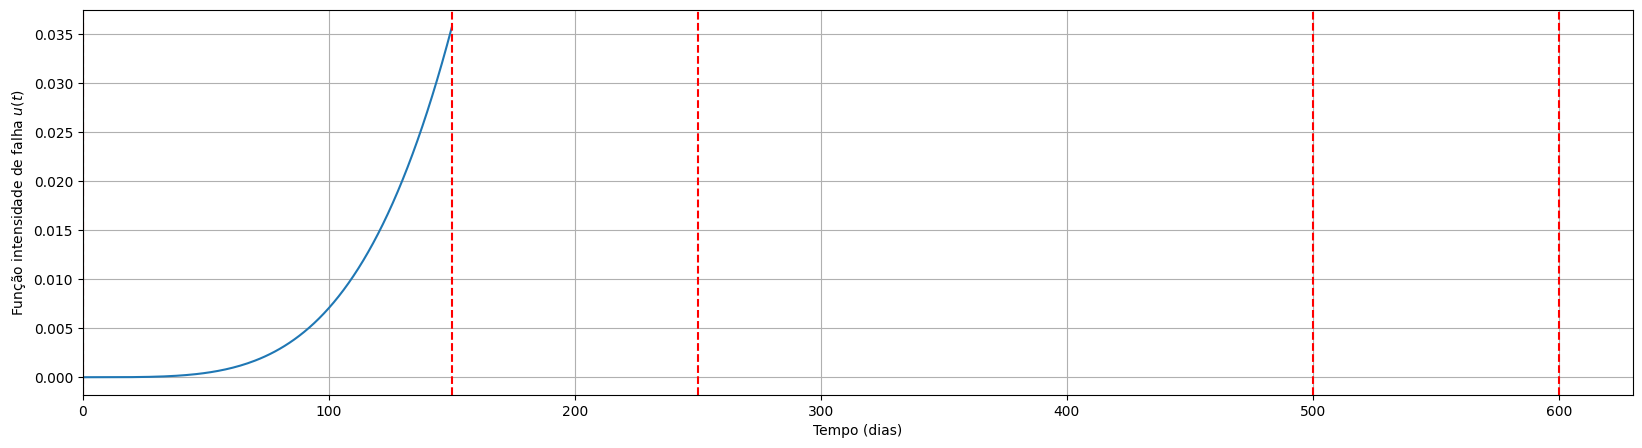

Fator ajuste:  [0.32320616229998167, 0.3861383609103921, 0.5845422254637207, 0.17732519322637674]


In [495]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Ajusta o modelo
lamb, beta, theta = adjust_model()

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

# Etapa 2: Otimização

In [496]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    cmp_f = dist[s]
    return cmp_f

In [497]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(X):
    # Dicionario para severidades
    dict = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    global s
    T = [0]
    s_row = []
    cont = 0

    for number in X:
        modulo = int(number) % 2
        if modulo == 1:
            inteiro = int(number)
            s_row.append(dict[inteiro])  # Severidade
            frac = number - inteiro  # Tempo
            t = (cont + frac) * 30
            T.append(int(t))
        cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

# A partir da solução define o número de ciclos
# A variável m é o número de sistemas em análise: em nosso exemplo m = 4
# Para novos dados esse parâmetro deve ser ajustado
# m = 4
    ck = len(T) - 1
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])

    if ck == 0:
        return MAX_VALUE_CUSTO

# O modelo já está ajustado
# Utilizado para avaliar a solução candidata

# Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

# Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

# Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)

    print('Custo = ', Custo)

    # Retorna o custo
    return Custo

Aplica AG para determinar tempos e severidades

Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 116, 156, 203, 221, 276, 309, 360, 539, 548, 597, 674, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 1.0, 0.5, 0.75, 0.5, 1.0, 0.25, 0.5]
Fator:  [0.17732519322637674, 0.21650677151004816, 0.3861383609103921, 0.5190435625435496, 0.21650677151004816, 0.5190435625435496, 0.62317388805422, 0.3861383609103921, 0.5190435625435496, 0.3861383609103921, 0.62317388805422, 0.21650677151004816, 0.3861383609103921]
Media de falhas:  [0, 0.29646177498656195, 0.8278162771548356, 2.401648579394823, 2.8102058088731576, 4.159463843559417, 11.06223445692676, 14.512473171766837, 57.4019971782596, 65.44006832406124, 89.59712626144548, 238.41019661401185, 256.1008722028448, 351.8000686301007]
Custo =  49551.213919943555
Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 89, 98, 196, 236, 247, 280, 325, 346, 393, 437, 466, 533, 542, 614, 630, 684]
Severidade para cada subsistema: [1

<ipython-input-497-1ee9b067cc27>:72: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))


Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 8, 48, 88, 97, 148, 179, 218, 240, 295, 327, 370, 398, 467, 501, 565, 602, 671, 702]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 1.0, 0.75, 0.5, 1.0, 0.25, 0.5, 1.0]
Fator:  [0.17732519322637674, 0.3861383609103921, 0.3861383609103921, 0.21650677151004816, 0.3861383609103921, 0.3861383609103921, 0.21650677151004816, 0.21650677151004816, 0.21650677151004816, 0.5190435625435496, 0.21650677151004816, 0.5190435625435496, 0.62317388805422, 0.5190435625435496, 0.3861383609103921, 0.62317388805422, 0.21650677151004816, 0.3861383609103921, 0.62317388805422]
Media de falhas:  [0, 4.625180578411274e-07, 0.003095863521991479, 0.025613113208868023, 0.0331503522832447, 0.46367737502563344, 0.7554815497546357, 1.5618563555579104, 3.270419075866708, 11.921019465265957, 20.41539243644172, 23.60490852629217, 40.52982853421801, 53.80878716384352, 57.18827581232462, 82.9522005

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


A saída de streaming foi truncada nas últimas 5000 linhas.
Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 104, 243, 301, 380, 506]
Severidade para cada subsistema: [1.0, 1.0, 0.75, 1.0, 0.25]
Fator:  [0.17732519322637674, 0.62317388805422, 0.62317388805422, 0.5190435625435496, 0.62317388805422, 0.21650677151004816]
Media de falhas:  [0, 0.17172971725000571, 8.1667968973091, 9.132460899623657, 12.591245118781309, 49.32331767300816, 218.83232604317385]
Custo =  5492.504096929691
Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 104, 169, 240, 380, 506]
Severidade para cada subsistema: [1.0, 0.5, 1.0, 1.0, 0.25]
Fator:  [0.17732519322637674, 0.62317388805422, 0.3861383609103921, 0.62317388805422, 0.62317388805422, 0.21650677151004816]
Media de falhas:  [0, 0.17172971725000571, 1.1989619074526228, 1.8097133917322392, 28.471385002482464, 47.574467862425735, 217.08347623259144]
Custo =  5202.5785359073625
Número de ciclos de manutenção

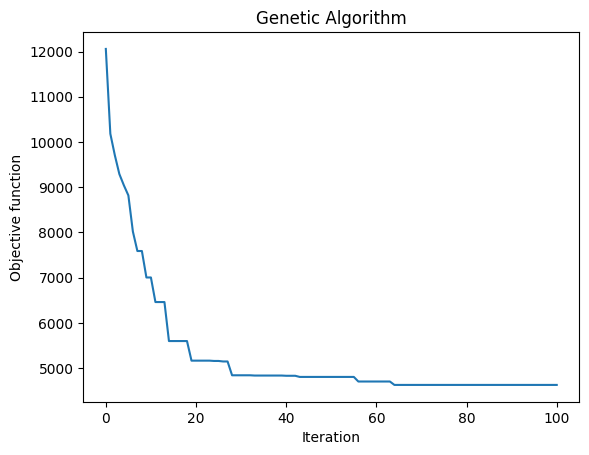

In [498]:
# Otimização da política de manutenção com AG
varbound = np.array([[0, 8]] * 24)

algorithm_param_ = {
    'max_num_iteration': 100,\
    'population_size': 100,\
    'mutation_probability': 0.05,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.75,\
    'parents_portion': 0.3,\
    'crossover_type': 'two_point',\
    'max_iteration_without_improv': None
}

model_=ga(
    function = objective_st,
    dimension = 24,
    variable_type = 'real',
    variable_boundaries = varbound,
    algorithm_parameters = algorithm_param_
)
model_.run()

In [499]:
sol = model_.best_variable

In [500]:
# Decodifica a solução encontrada
dict = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}
T = [0]
s_row = []
cont = 0

for number in sol:
    modulo = int(number) % 2
    if modulo == 1:
        inteiro = int(number)
        s_row.append(dict[inteiro])  # Severidade
        frac = number - inteiro  # Tempo
        t = (cont + frac) * 30
        T.append(int(t))
    cont += 1

s = []
for row in range(m):
    s.append(s_row)

# A partir da solução define o número de ciclos
ck = len(T) - 1

print('Número de ciclos de manutenção:', ck)
print('Tempos para manutenções preventivas:', T)
print('Severidade para cada subsistema:', s[0])

Número de ciclos de manutenção: 4
Tempos para manutenções preventivas: [0, 104, 240, 380, 506]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 0.25]
